In [276]:
import os
from bs4 import BeautifulSoup
from lxml import html
import re
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from annoy import AnnoyIndex
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
import matplotlib.pyplot as plt
import spacy
import re
#pip install pyyaml
import yaml
#яндекс спеллер
#!python -m pip install pyaspeller
from pyaspeller import YandexSpeller

speller = YandexSpeller()

In [128]:
temp = pd.read_csv("пример.csv")
temp

,Было,Стало
0,зам.нач. Производства,заместитель начальника производства
1,заместитель начальника производства,заместитель начальника производства
2,главбух,главный бухгалтер
3,гл вет врач,главный ветеринарный врач
4,гл. ветврач,главный ветеринарный врач


In [159]:
with open("names.yaml", "r", encoding='utf8') as file:
    names = yaml.safe_load(file)
#экранируем точки
names = {k.replace('.','\.'):v for k,v in names.items()}
print(names)

{'зам\\.': 'заместитель ', 'зав\\.': 'заведующий ', 'нач\\.': 'начальник ', 'рук\\.': 'руководитель ', 'ген\\.': 'генеральный ', 'гл ': 'главный ', 'гл\\.': 'главный ', 'гендиректор': 'генеральный директор', 'главбух': 'главный бухгалтер', 'ветврач': 'ветеринарный врач', 'вет врач': 'ветеринарный врач', '–': '-', ' - ': '-'}


In [ ]:
!pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.1.0/ru_core_news_sm-3.1.0.tar.gz

In [44]:
#очистка текста

lemmatizer = spacy.load('ru_core_news_md', disable = ['parser', 'ner'])
stopwords_nltk=[]

def full_clean(s):
    #подготовка текста к подаче в модель
    s=re.sub(r"[^a-zA-Zа-яА-ЯйЙ#]", " ", s)
    s = s.lower()
    s = re.sub(" +", " ", s) #оставляем только 1 пробел
    text = " ".join([token.lemma_ for token in lemmatizer(s) if token.lemma_ not in stopwords_nltk])
    
    return text


def make_speller(s):
    # проверка орфографии яндекс спеллером
    fixed = speller.spelled(s)
    return fixed

In [5]:
def get_resume(dirPath):
    #список резюме
    result = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
    i=0
    idx=[]
    title=[]
    text=[]
    #считываем резюме и получаем текст назыания и содержания профессии
    for res in tqdm(result):
        texts = open(dirPath + '/' + res, 'r').read()
        bs = BeautifulSoup(texts,'lxml')
        ps = bs.find_all(attrs={'class': 'bloko-text bloko-text_strong', 'data-qa': 'resume-block-experience-position'})
        for p in ps:
            idx.append(i)
            title.append(p.get_text())
            text.append(p.find_next_sibling().text)  
        i+=1
        
    return pd.DataFrame(data={'Резюме': idx, 'Профессия': title, 'Обязанности': text})

In [84]:
def tfidf_featuring_(tfidf, df):   
    '''Преобразование текста в мешок слов'''
    X_tfidf = tfidf.transform(df)
    #feature_names = tfidf.get_feature_names_out()
    #X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = feature_names, index = df.index)
    
    return X_tfidf.toarray().tolist()

Словарь профессий

In [193]:
sprav = pd.read_csv("справочник.csv")[['Должность', 'Должностные обязанности']]
sprav['Должность'] = sprav['Должность'].str.lower()
sprav

,Должность,Должностные обязанности
0,"директор (генеральный директор, управляющий) п...",Руководит в соответствии с действующим законод...
1,финансовый директор (заместитель директора по ...,"Определяет финансовую политику организации, ра..."
2,главный бухгалтер,Организует работу по постановке и ведению бухг...
3,главный диспетчер,Обеспечивает ритмичную работу предприятия и ра...
4,главный инженер,Определяет техническую политику и направления ...
...,...,...
456,бригадир,организация работ и ведение технологического п...
457,электрогазосварщик,Ручная кислородная резка и резка бензорезатель...
458,электрогазосварщик,"Ручная дуговая, плазменная и газовая сварка ос..."
459,государственный ветеринарный инспектор,Государственный контроль за выполнением требов...


In [194]:
sprav['prof_clean'] = sprav['Должность'].progress_apply(lambda x: full_clean(x))
sprav['text_clean'] = sprav['Должностные обязанности'].progress_apply(lambda x: full_clean(x))

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

In [195]:
sprav

,Должность,Должностные обязанности,prof_clean,text_clean
0,"директор (генеральный директор, управляющий) п...",Руководит в соответствии с действующим законод...,директор генеральный директор управлять предпр...,руководить в соответствие с действовать законо...
1,финансовый директор (заместитель директора по ...,"Определяет финансовую политику организации, ра...",финансовый директор заместитель директор по фи...,определять финансовый политика организация раз...
2,главный бухгалтер,Организует работу по постановке и ведению бухг...,главный бухгалтер,организовать работа по постановка и ведение бу...
3,главный диспетчер,Обеспечивает ритмичную работу предприятия и ра...,главный диспетчер,обеспечивать ритмичный работа предприятие и ра...
4,главный инженер,Определяет техническую политику и направления ...,главный инженер,определять технический политика и направление ...
...,...,...,...,...
456,бригадир,организация работ и ведение технологического п...,бригадир,организация работа и ведение технологический п...
457,электрогазосварщик,Ручная кислородная резка и резка бензорезатель...,электрогазосварщик,ручной кислородный резка и резка бензорезатель...
458,электрогазосварщик,"Ручная дуговая, плазменная и газовая сварка ос...",электрогазосварщик,ручной дуговой плазменный и газовый сварка осо...
459,государственный ветеринарный инспектор,Государственный контроль за выполнением требов...,государственный ветеринарный инспектор,государственный контроль за выполнение требова...


Резюме

In [64]:
data = get_resume("resumes")
data['Профессия'] = data['Профессия'].str.lower()
#орфография
data['Профессия'] = data['Профессия'].progress_apply(lambda x: make_speller(x))
data

  0%|          | 0/1001 [00:00<?, ?it/s]

,Резюме,Профессия,Обязанности
0,0,контролер качества,1) Ежесменный аудит производства: \n- выявлени...
1,0,заместитель начальника производства,"- Организация ежедневной работы персонала, сос..."
2,0,контролер качества,- Входной контроль поступающего на производств...
3,0,мастер участка бескостной группы,- Работа по производству филе бедра ЦБ.\n- Обе...
4,0,мастер участка заморозки мпп,-Производство говяжьего фарша.\n- Работа по за...
...,...,...,...
4330,999,водитель,-Управление автомобилем. \n-Обеспечивает своев...
4331,999,инженер,"- Обеспечение безопасной, бесперебойной и техн..."
4332,999,водитель,-Управление автомобилем. \n\n-Управление подъе...
4333,1000,ветеринарный врач 1 категории,Работа на ветеринарном участке - проведение п...


In [161]:
data['Профессия'] = data['Профессия'].replace(names, regex=True)
data

,Резюме,Профессия,Обязанности,prof_clean,text_clean,embeding,predict,embeding_t,predict_t
0,0,контролер качества,1) Ежесменный аудит производства: \n- выявлени...,контролёр качество,ежесменный аудит производство выявление нару...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник производственной лаборатории (по кон...
1,0,заместитель начальника производства,"- Организация ежедневной работы персонала, сос...",заместитель начальник производство,организация ежедневный работа персонал соста...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник цеха опытного производства,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",менеджер по персоналу
2,0,контролер качества,- Входной контроль поступающего на производств...,контролёр качество,входной контроль поступать на производство с...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник производственной лаборатории (по кон...
3,0,мастер участка бескостной группы,- Работа по производству филе бедра ЦБ.\n- Обе...,мастер участок бескостный группа,работа по производство филе бедро цб обеспеч...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник отдела контроля качества
4,0,мастер участка заморозки мпп,-Производство говяжьего фарша.\n- Работа по за...,мастер участок заморозка мпп,производство говяжий фарш работа по заморозк...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник отдела контроля качества
...,...,...,...,...,...,...,...,...,...
4330,999,водитель,-Управление автомобилем. \n-Обеспечивает своев...,водитель,управление автомобиль обеспечивать своевреме...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4331,999,инженер,"- Обеспечение безопасной, бесперебойной и техн...",инженер,обеспечение безопасный бесперебойный и техни...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",инженер,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",слесарь по обслуживанию и ремонту оборудования
4332,999,водитель,-Управление автомобилем. \n\n-Управление подъе...,водитель,управление автомобиль управление подъёмный м...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4333,1000,ветеринарный врач 1 категории,Работа на ветеринарном участке - проведение п...,ветеринарный врач категория,работа на ветеринарный участок проведение прот...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ветеринарный врач,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",оператор по ветеринарной обработке животных


In [162]:
data['prof_clean'] = data['Профессия'].progress_apply(lambda x: full_clean(x))
data['text_clean'] = data['Обязанности'].progress_apply(lambda x: full_clean(x))
data

  0%|          | 0/4335 [00:00<?, ?it/s]

  0%|          | 0/4335 [00:00<?, ?it/s]

,Резюме,Профессия,Обязанности,prof_clean,text_clean,embeding,predict,embeding_t,predict_t
0,0,контролер качества,1) Ежесменный аудит производства: \n- выявлени...,контролёр качество,ежесменный аудит производство выявление нару...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник производственной лаборатории (по кон...
1,0,заместитель начальника производства,"- Организация ежедневной работы персонала, сос...",заместитель начальник производство,организация ежедневный работа персонал соста...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник цеха опытного производства,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",менеджер по персоналу
2,0,контролер качества,- Входной контроль поступающего на производств...,контролёр качество,входной контроль поступать на производство с...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник производственной лаборатории (по кон...
3,0,мастер участка бескостной группы,- Работа по производству филе бедра ЦБ.\n- Обе...,мастер участок бескостный группа,работа по производство филе бедро цб обеспеч...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник отдела контроля качества
4,0,мастер участка заморозки мпп,-Производство говяжьего фарша.\n- Работа по за...,мастер участок заморозка мпп,производство говяжий фарш работа по заморозк...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник отдела контроля качества
...,...,...,...,...,...,...,...,...,...
4330,999,водитель,-Управление автомобилем. \n-Обеспечивает своев...,водитель,управление автомобиль обеспечивать своевреме...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4331,999,инженер,"- Обеспечение безопасной, бесперебойной и техн...",инженер,обеспечение безопасный бесперебойный и техни...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",инженер,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",слесарь по обслуживанию и ремонту оборудования
4332,999,водитель,-Управление автомобилем. \n\n-Управление подъе...,водитель,управление автомобиль управление подъёмный м...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4333,1000,ветеринарный врач 1 категории,Работа на ветеринарном участке - проведение п...,ветеринарный врач категория,работа на ветеринарный участок проведение прот...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ветеринарный врач,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",оператор по ветеринарной обработке животных


Векторы названий

In [196]:
#тренировка модели token_pattern=r'(?u)\b\w\w+\b'
tfidf = TfidfVectorizer(max_features=800, #max_df = 0.9,
                        #analyzer='char_wb', ngram_range=(3, 5), 
                        analyzer='word', ngram_range=(1, 1), 
                        #token_pattern=r'(?u)\b[а-яА-ЯёЁa-zA-Z][а-яА-ЯёЁa-zA-Z]+\b',
                        #tokenizer=lemmatize,
                        lowercase = True, sublinear_tf=True)
tfidf.fit(pd.concat([data['prof_clean'].drop_duplicates(), sprav['prof_clean'].drop_duplicates()]))

TfidfVectorizer(max_features=800, sublinear_tf=True)

Векторы описаний

In [197]:
#тренировка модели token_pattern=r'(?u)\b\w\w+\b'
tfidf_t = TfidfVectorizer(max_features=2000, max_df = 0.9,
                        #analyzer='char_wb', ngram_range=(3, 5), 
                        analyzer='word', ngram_range=(1, 1), 
                        #token_pattern=r'(?u)\b[а-яА-ЯёЁa-zA-Z][а-яА-ЯёЁa-zA-Z]+\b',
                        #tokenizer=lemmatize,
                        lowercase = True, sublinear_tf=True)
tfidf_t.fit(pd.concat([data['text_clean'], sprav['text_clean']]))

TfidfVectorizer(max_df=0.9, max_features=2000, sublinear_tf=True)

In [200]:
sprav['embeding'] = tfidf_featuring_(tfidf, sprav['prof_clean'])
sprav['embeding_t'] = tfidf_featuring_(tfidf, sprav['text_clean'])
sprav

,Должность,Должностные обязанности,prof_clean,text_clean,embeding,embeding_t
0,"директор (генеральный директор, управляющий) п...",Руководит в соответствии с действующим законод...,директор генеральный директор управлять предпр...,руководить в соответствие с действовать законо...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,финансовый директор (заместитель директора по ...,"Определяет финансовую политику организации, ра...",финансовый директор заместитель директор по фи...,определять финансовый политика организация раз...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,главный бухгалтер,Организует работу по постановке и ведению бухг...,главный бухгалтер,организовать работа по постановка и ведение бу...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,главный диспетчер,Обеспечивает ритмичную работу предприятия и ра...,главный диспетчер,обеспечивать ритмичный работа предприятие и ра...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,главный инженер,Определяет техническую политику и направления ...,главный инженер,определять технический политика и направление ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
456,бригадир,организация работ и ведение технологического п...,бригадир,организация работа и ведение технологический п...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
457,электрогазосварщик,Ручная кислородная резка и резка бензорезатель...,электрогазосварщик,ручной кислородный резка и резка бензорезатель...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
458,электрогазосварщик,"Ручная дуговая, плазменная и газовая сварка ос...",электрогазосварщик,ручной дуговой плазменный и газовый сварка осо...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
459,государственный ветеринарный инспектор,Государственный контроль за выполнением требов...,государственный ветеринарный инспектор,государственный контроль за выполнение требова...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [201]:
data['embeding'] = tfidf_featuring_(tfidf, data['prof_clean'])
data['embeding_t'] = tfidf_featuring_(tfidf, data['text_clean'])
data

,Резюме,Профессия,Обязанности,prof_clean,text_clean,embeding,predict,embeding_t,predict_t
0,0,контролер качества,1) Ежесменный аудит производства: \n- выявлени...,контролёр качество,ежесменный аудит производство выявление нару...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник производственной лаборатории (по кон...
1,0,заместитель начальника производства,"- Организация ежедневной работы персонала, сос...",заместитель начальник производство,организация ежедневный работа персонал соста...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник цеха опытного производства,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",менеджер по персоналу
2,0,контролер качества,- Входной контроль поступающего на производств...,контролёр качество,входной контроль поступать на производство с...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник производственной лаборатории (по кон...
3,0,мастер участка бескостной группы,- Работа по производству филе бедра ЦБ.\n- Обе...,мастер участок бескостный группа,работа по производство филе бедро цб обеспеч...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник смены
4,0,мастер участка заморозки мпп,-Производство говяжьего фарша.\n- Работа по за...,мастер участок заморозка мпп,производство говяжий фарш работа по заморозк...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник смены
...,...,...,...,...,...,...,...,...,...
4330,999,водитель,-Управление автомобилем. \n-Обеспечивает своев...,водитель,управление автомобиль обеспечивать своевреме...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4331,999,инженер,"- Обеспечение безопасной, бесперебойной и техн...",инженер,обеспечение безопасный бесперебойный и техни...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",инженер,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",слесарь по обслуживанию и ремонту оборудования
4332,999,водитель,-Управление автомобилем. \n\n-Управление подъе...,водитель,управление автомобиль управление подъёмный м...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4333,1000,ветеринарный врач 1 категории,Работа на ветеринарном участке - проведение п...,ветеринарный врач категория,работа на ветеринарный участок проведение прот...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ветеринарный врач,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",заведующий ветеринарным участком


Индексы по названиям

In [202]:
def predict_nns(t, x):
    idx = t.get_nns_by_vector(x, 1, search_k=-1)  
    return sprav['Должность'][idx].values[0]

In [203]:
#"angular", "euclidean", "manhattan", "hamming", or "dot" 384 768 1024
emb_len = len(sprav['embeding'][0])
t = AnnoyIndex(emb_len, metric = 'angular')

# train['id'], 
for user_id, user_embedding in enumerate(sprav['embeding']):
    t.add_item(user_id, user_embedding)
t.build(-1)

True

Индексы по содержанию

In [204]:
emb_len = len(sprav['embeding_t'][0])
t_t = AnnoyIndex(emb_len, metric = 'angular')

for user_id, user_embedding in enumerate(sprav['embeding_t']):
    t_t.add_item(user_id, user_embedding)
t_t.build(-1)

True

In [205]:
data["predict"]=data["embeding"].progress_apply(lambda x: predict_nns(t, x))
data["predict_t"]=data["embeding_t"].progress_apply(lambda x: predict_nns(t, x))
data

  0%|          | 0/4335 [00:00<?, ?it/s]

  0%|          | 0/4335 [00:00<?, ?it/s]

,Резюме,Профессия,Обязанности,prof_clean,text_clean,embeding,predict,embeding_t,predict_t
0,0,контролер качества,1) Ежесменный аудит производства: \n- выявлени...,контролёр качество,ежесменный аудит производство выявление нару...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник производственной лаборатории (по кон...
1,0,заместитель начальника производства,"- Организация ежедневной работы персонала, сос...",заместитель начальник производство,организация ежедневный работа персонал соста...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник цеха опытного производства,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",менеджер по персоналу
2,0,контролер качества,- Входной контроль поступающего на производств...,контролёр качество,входной контроль поступать на производство с...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",контролер качества,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",заведующий лабораторией по наблюдениям за режи...
3,0,мастер участка бескостной группы,- Работа по производству филе бедра ЦБ.\n- Обе...,мастер участок бескостный группа,работа по производство филе бедро цб обеспеч...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник смены
4,0,мастер участка заморозки мпп,-Производство говяжьего фарша.\n- Работа по за...,мастер участок заморозка мпп,производство говяжий фарш работа по заморозк...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",мастер участка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",начальник смены
...,...,...,...,...,...,...,...,...,...
4330,999,водитель,-Управление автомобилем. \n-Обеспечивает своев...,водитель,управление автомобиль обеспечивать своевреме...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4331,999,инженер,"- Обеспечение безопасной, бесперебойной и техн...",инженер,обеспечение безопасный бесперебойный и техни...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",инженер,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",слесарь по обслуживанию и ремонту оборудования
4332,999,водитель,-Управление автомобилем. \n\n-Управление подъе...,водитель,управление автомобиль управление подъёмный м...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель аэросаней,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",водитель автомобиля
4333,1000,ветеринарный врач 1 категории,Работа на ветеринарном участке - проведение п...,ветеринарный врач категория,работа на ветеринарный участок проведение прот...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ветеринарный врач,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",заведующий ветеринарным участком


In [275]:
#сохранение результата кластеризации
data[['Резюме', 'Профессия', 'Обязанности', 'predict']].to_csv("predict.csv", index=False)

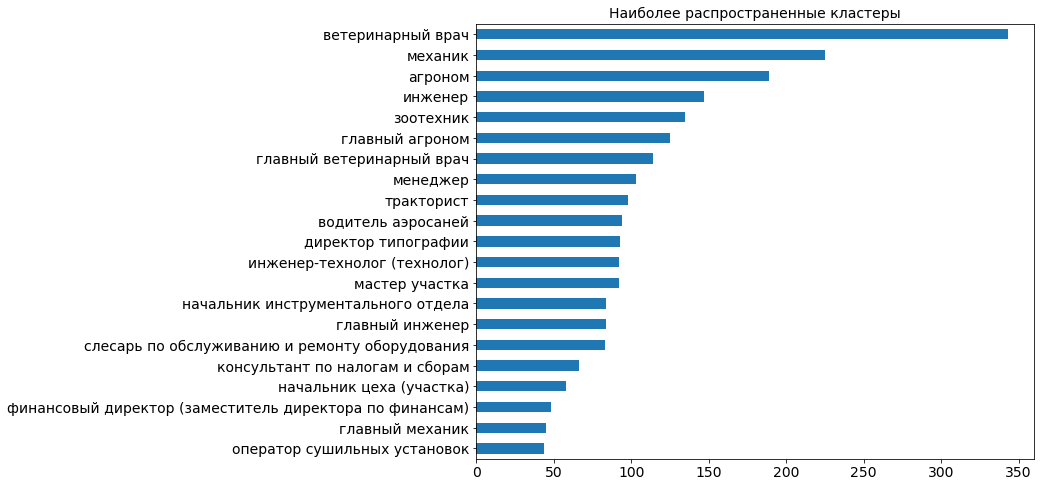

In [242]:
plt.figure(figsize=(10,8))
data['predict'].value_counts()[1:22].sort_values().plot(kind='barh', fontsize=14)
plt.title("Наиболее распространенные кластеры", fontsize=14) 
plt.show()

In [207]:
data['predict_t'].value_counts()

слесарь по обслуживанию и ремонту оборудования              288
директор (генеральный директор, управляющий) предприятия    243
начальник отдела контроля качества                          201
инженер по организации труда                                198
инспектор по контролю за исполнением поручений              188
                                                           ... 
инженер-программист (программист)                             1
начальник центральной заводской лаборатории                   1
сторож (вахтер)                                               1
инструктор-дактилолог                                         1
машинист подъемной машины                                     1
Name: predict_t, Length: 211, dtype: int64

In [254]:
regexp=r'(?u)\b\w{4,}\b'

def plot_word_cloud(text, picture_fn=None, stopwords=None,
                    normalize=True, regexp=r'(?u)\b\w{4,}\b', **wc_kwargs):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    if stopwords:
        words = remove_stopwords(words, stopwords)
    wc = WordCloud(**wc_kwargs).generate(' '.join(words))
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(picture_fn)

(-0.5, 399.5, 199.5, -0.5)

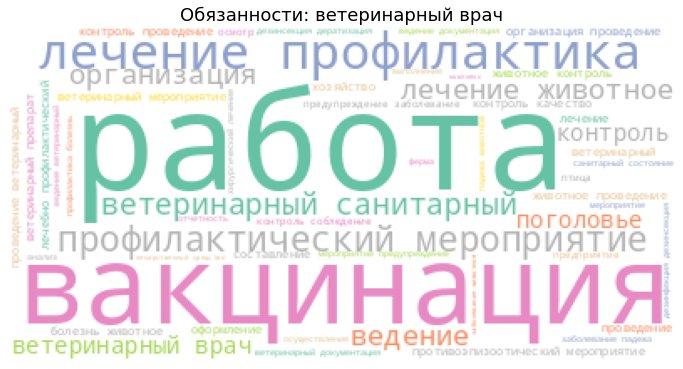

In [270]:
pred = "ветеринарный врач"

text = str(data[data['predict']==pred]['text_clean'].tolist())

words = [w for sent in sent_tokenize(text) for w in regexp_tokenize(sent, regexp)]

wordCloud = WordCloud(random_state=1, background_color='white', colormap='Set2', 
                      max_words=100).generate(' '.join(words))

plt.figure(figsize=(12,12))
plt.title('Обязанности: ' + pred , fontsize=18) 
plt.imshow(wordCloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

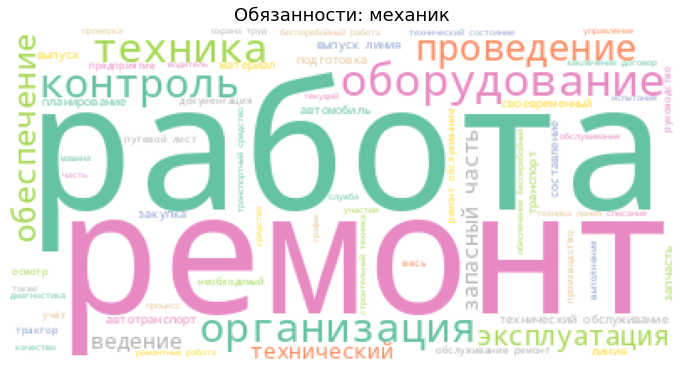

In [271]:
pred = "механик"

text = str(data[data['predict']==pred]['text_clean'].tolist())

words = [w for sent in sent_tokenize(text) for w in regexp_tokenize(sent, regexp)]

wordCloud = WordCloud(random_state=1, background_color='white', colormap='Set2', 
                      max_words=100).generate(' '.join(words))

plt.figure(figsize=(12,12))
plt.title('Обязанности: ' + pred , fontsize=18) 
plt.imshow(wordCloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

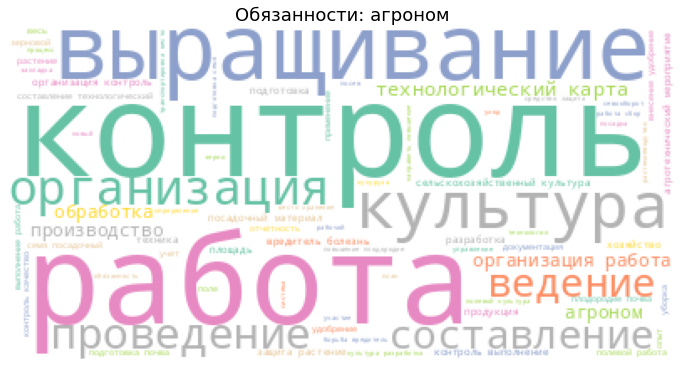

In [272]:
pred = "агроном"

text = str(data[data['predict']==pred]['text_clean'].tolist())

words = [w for sent in sent_tokenize(text) for w in regexp_tokenize(sent, regexp)]

wordCloud = WordCloud(random_state=1, background_color='white', colormap='Set2', 
                      max_words=100).generate(' '.join(words))

plt.figure(figsize=(12,12))
plt.title('Обязанности: ' + pred , fontsize=18) 
plt.imshow(wordCloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

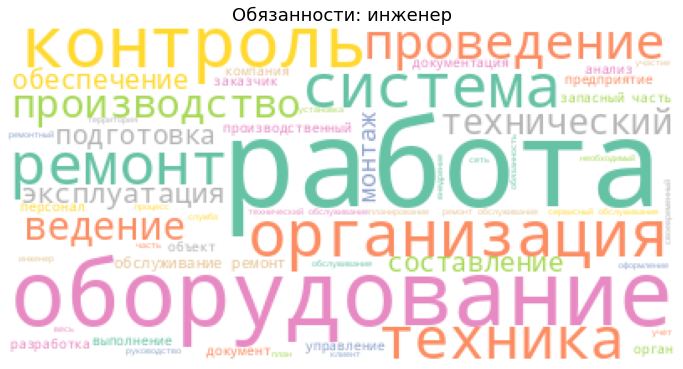

In [273]:
pred = "инженер"

text = str(data[data['predict']==pred]['text_clean'].tolist())

words = [w for sent in sent_tokenize(text) for w in regexp_tokenize(sent, regexp)]

wordCloud = WordCloud(random_state=1, background_color='white', colormap='Set2', 
                      max_words=100).generate(' '.join(words))

plt.figure(figsize=(12,12))
plt.title('Обязанности: ' + pred , fontsize=18) 
plt.imshow(wordCloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

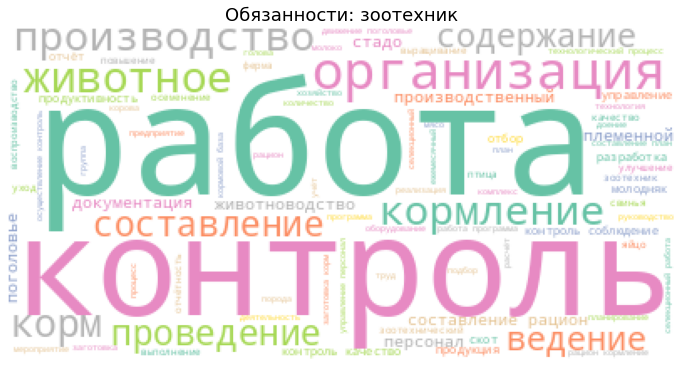

In [274]:
pred = "зоотехник"

text = str(data[data['predict']==pred]['text_clean'].tolist())

words = [w for sent in sent_tokenize(text) for w in regexp_tokenize(sent, regexp)]

wordCloud = WordCloud(random_state=1, background_color='white', colormap='Set2', 
                      max_words=100).generate(' '.join(words))

plt.figure(figsize=(12,12))
plt.title('Обязанности: ' + pred , fontsize=18) 
plt.imshow(wordCloud)
plt.axis("off")

In [253]:
data[data['predict']=='ветеринарный врач']['Обязанности']

39      Проведение аудита в хозяйствах всех форм собст...
41      Оформление ЭВСД в ФГИС "Меркурий", ветеринарна...
43      Оформление ЭВСД в ФГИС "Меркурий", ветеринарна...
58      Диагностика и сбор анамнеза состояния здоровья...
80      Ведение ветеринарной документации. Транзит 2 м...
                              ...                        
4299    Лечение и профилактика заболеваний молодняка и...
4300    Ректальная диагностика, лечение и профилактика...
4301    Лечение и профилактика заболеваний молодняка и...
4333    Работа на ветеринарном участке -  проведение п...
4334    Лечение, профилактика болезней инфекционных и ...
Name: Обязанности, Length: 343, dtype: object

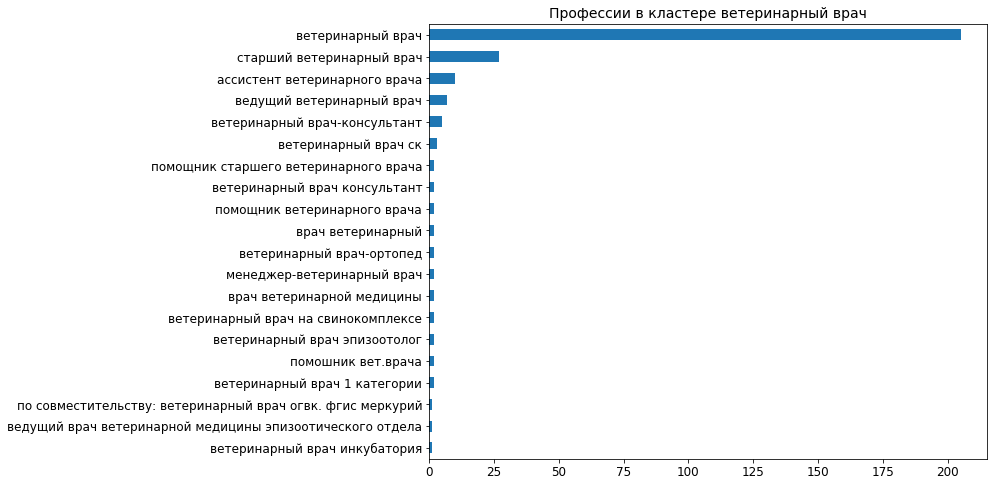

In [246]:
pred = 'ветеринарный врач'

plt.figure(figsize=(10,8))
data[data['predict']==pred]['Профессия'].value_counts(ascending=False)[0:20].sort_values().plot(kind='barh', fontsize=12)
plt.title('Профессии в кластере ' + pred , fontsize=14) 
plt.show()

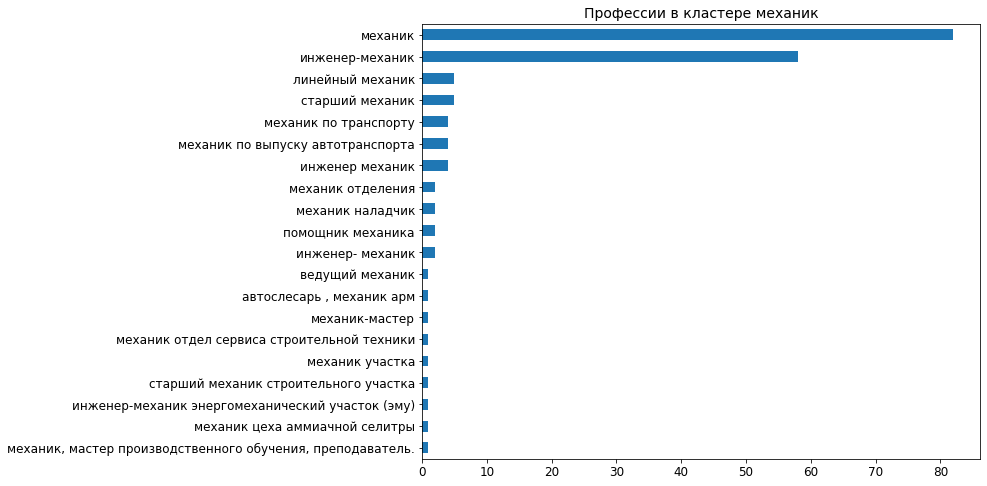

In [247]:
pred = 'механик'

plt.figure(figsize=(10,8))
data[data['predict']==pred]['Профессия'].value_counts(ascending=False)[0:20].sort_values().plot(kind='barh', fontsize=12)
plt.title('Профессии в кластере ' + pred , fontsize=14) 
plt.show()

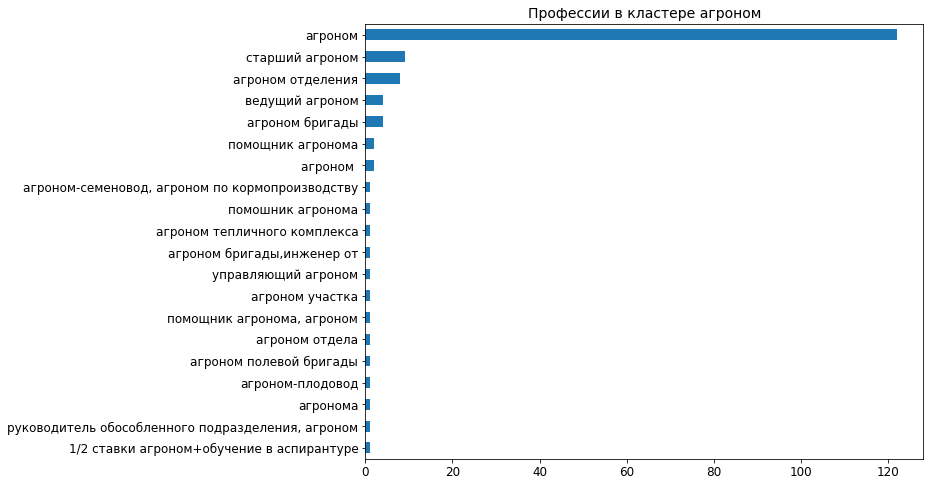

In [248]:
pred = 'агроном'

plt.figure(figsize=(10,8))
data[data['predict']==pred]['Профессия'].value_counts(ascending=False)[0:20].sort_values().plot(kind='barh', fontsize=12)
plt.title('Профессии в кластере ' + pred , fontsize=14) 
plt.show()

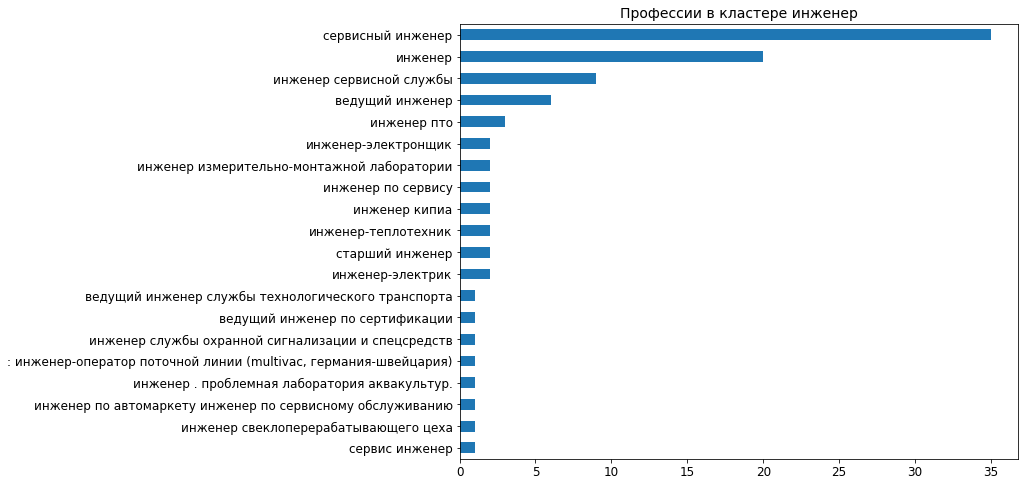

In [249]:
pred = 'инженер'

plt.figure(figsize=(10,8))
data[data['predict']==pred]['Профессия'].value_counts(ascending=False)[0:20].sort_values().plot(kind='barh', fontsize=12)
plt.title('Профессии в кластере ' + pred , fontsize=14) 
plt.show()

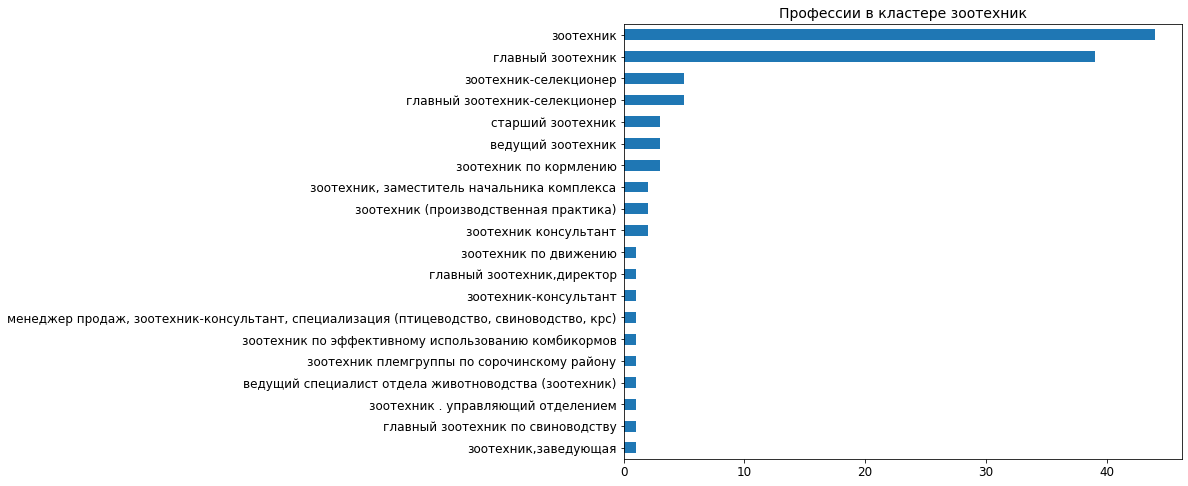

In [250]:
pred = 'зоотехник'

plt.figure(figsize=(10,8))
data[data['predict']==pred]['Профессия'].value_counts(ascending=False)[0:20].sort_values().plot(kind='barh', fontsize=12)
plt.title('Профессии в кластере ' + pred , fontsize=14) 
plt.show()

In [208]:
data[data['predict']=='директор (генеральный директор, управляющий) предприятия']

,Резюме,Профессия,Обязанности,prof_clean,text_clean,embeding,predict,embeding_t,predict_t
12,2,вакцинатор,Иммунологическая кастрация хряков,вакцинатор,иммунологический кастрация хряк,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п..."
30,7,практикант,Обслуживание оборудования лёгкой промышленности.,практикант,обслуживание оборудование л гкой промышленность,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",слесарь по обслуживанию и ремонту оборудования
98,24,сыродел,Производство различных видов сыра,сыродел,производство различный вид сыр,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",инженер по подготовке производства
99,24,сыродел,Производство различных видов сыра,сыродел,производство различный вид сыр,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",инженер по подготовке производства
113,29,госветинспектор,Гос-ве инспектор на границе и транспорте.,госветинспектор,гос ве инспектор на граница и транспорт,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",государственный ветеринарный инспектор
...,...,...,...,...,...,...,...,...,...
4213,971,аппаратчик синтеза,Подготовка и осмотр аппаратов для последующей ...,аппаратчик синтез,подготовка и осмотр аппарат для последующий за...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",заготовитель продуктов и сырья
4225,974,глава кфх,производство и реализация с/х продукции,глава кфх,производство и реализация с х продукция,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",инженер по подготовке производства
4243,978,младший научный сотрудник,проведение исследований и разработка технологи...,младший научный сотрудник,проведение исследование и разработка технологи...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",методист по физической культуре
4270,985,глава,Растениеводство,глава,растениеводство,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","директор (генеральный директор, управляющий) п..."
